In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
%matplotlib inline

In [26]:
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
drive.mount('/content/drive')

img_width, img_height = 220, 220
n_classes = 2
#train_data_dir = '/home/kazzastic/Desktop/CV/Deep Learning/data/train'

Mounted at /content/drive


In [0]:
train_data_dir = '/content/drive/My Drive/train'
#validation_data_dir = '/content/drive/My Drive/test'

In [28]:
# Pixel values rescaling from [0, 255] to [0, 1] interval
datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.3)
batch_size = 32

# Retrieve images and their classes for train and validation sets
train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        shuffle = True,
        batch_size=batch_size,
        subset = 'training')

validation_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        shuffle = True,
        batch_size=batch_size,
        subset = 'validation')


Found 5930 images belonging to 2 classes.
Found 2540 images belonging to 2 classes.


In [30]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam 
#import pickle
import time

model = Sequential()

model.add(Conv2D(32, (3, 3),padding = 'same', input_shape=(220,220,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))


model.add(Conv2D(64, (3, 3),  padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = 2))

model.add(Conv2D(128, (3,3), padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides = 2))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64, activation = 'relu'))
#model.add(Dense(84, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation('softmax'))

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'],
              )

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 220, 220, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 220, 220, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 110, 110, 64)      18496     
_________________________________________________________________
activation_7 (Activation)    (None, 110, 110, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 55, 55, 128)      

In [0]:
epochs = 3
#train_samples = 8470
#validation_samples = 621

In [32]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Model saving callback

checkpointer = ModelCheckpoint(filepath='basic_cnn.h5', monitor='val_acc', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

history = model.fit_generator(
        train_generator,
        steps_per_epoch=32,
        epochs=epochs,
        validation_data = validation_generator,
        validation_steps = 32,
        callbacks=[checkpointer, early_stopping],
        verbose=1)

Epoch 1/3
31/32 [============================>.] - ETA: 18s - loss: 0.8166 - acc: 0.7016
Epoch 00001: val_acc improved from -inf to 0.83984, saving model to basic_cnn.h5
32/32 [==============================] - 1022s 32s/step - loss: 0.8025 - acc: 0.7070 - val_loss: 0.3692 - val_acc: 0.8398
Epoch 2/3
31/32 [============================>.] - ETA: 14s - loss: 0.4024 - acc: 0.8327
Epoch 00002: val_acc improved from 0.83984 to 0.87402, saving model to basic_cnn.h5
32/32 [==============================] - 741s 23s/step - loss: 0.3990 - acc: 0.8350 - val_loss: 0.2935 - val_acc: 0.8740
Epoch 3/3
31/32 [============================>.] - ETA: 14s - loss: 0.3483 - acc: 0.8710
Epoch 00003: val_acc did not improve from 0.87402
32/32 [==============================] - 741s 23s/step - loss: 0.3503 - acc: 0.8662 - val_loss: 0.3471 - val_acc: 0.8438


In [0]:
model.save("NIC-CNN.model")

In [35]:
import cv2
import tensorflow as tf
#from google.colab.patches import cv2_imshow

CATEGORIES = ["NIC", "WHITE-HOUSE"]


def prepare(filepath):
    IMG_SIZE = 220 # 50 in txt-based
    img_array = cv2.imread(filepath)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)


model = tf.keras.models.load_model("NIC-CNN.model")

prediction = model.predict([prepare('nic.jpg')])
print(prediction)  # will be a list in a list.
print(CATEGORIES[int(prediction[0][0])])

[[1. 0.]]
WHITE-HOUSE


In [17]:
validation_samples = 2540
model.evaluate_generator(validation_generator, validation_samples, workers=12, verbose=1)

FileNotFoundError: ignored

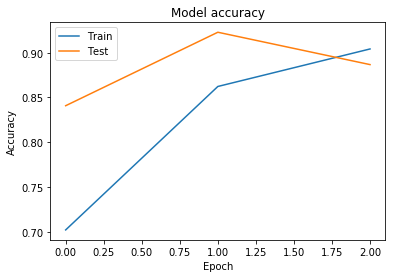

In [16]:
fig, ax = plt.subplots()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
fig.savefig('basic_cnn.svg', format='svg', dpi=1200)